# 本文档用于因子的开发和参数测试

## 因子计算流程：
1. FactorCalculator类：
   1. 传入相应的原始数据（每一个表包含单一标的的数据）
   2. 定义单一标的因子的计算方式
   3. 输出单一标的因子的series

2. FactorConstructor类：
   1. 调用对应的FactorCalculator，计算所有标的的因子值

3. FactorsInitializer类：
   1. 调用所有的FactorConstructor类，在研发时完成因子的初始化


## 时间说明
1. 由于在Backtester中所使用的回测价格为open.shift(2) - open.shift(1); 因此每个因子可以使用的数据为本日收盘后的所有数据

## 因子

1. **财务数据因子：F_Score**
   1. F_Score计算方式可见idea.ipynb
   2. 读取财务数据和股权变动数据
   3. 打分均使用一年的差分，无参数需要测试


2. **反转因子：Momemtum**:
   1. 计算方式：log(今日收盘价)-log(若干天前收盘价)
   2. 读取close价格数据
   3. 测试参数:
      1. close计算对数收益率的时间跨度
      2. **不**需要取多个时点反转的均值：数学上等于延长上一条的窗口期
   
3. **估值因子：valuation**
   1. 计算方式：当日的market_cap

研究思路：
1. Fscore和Momentum第0组的收益率差异：新股上市第一年和第二年的表现差异？？？

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import jqdatasdk as jqdata
from tqdm import tqdm
import sqlite3
from abc import abstractmethod
import datetime
import itertools

In [2]:
'''
Description: 
Author: czl
Date: 2023-07-21 16:19:19
LastEditTime: 2023-08-05 19:35:11
LastEditors:  
'''
from const import *   # import the const.
from classes.basic_calculator import STOCK_LIST, TRADE_DATE_LIST
from classes.basic_functions import DateCalculator, index_columns_check
from classes.data_downloader import DailyPriceDataDownloader, DailyValuationDataDownloader, DailyFinancialDataDownloader, CertainEquityDataDownloader
from classes.data_reader import DailyPriceDataReader, DailyValuationDataReader, DailyFinancialDataReader, CertainEquityDataReader, CrossPriceDataReader, CrossValuationDataReader, FscoreDataReader
from classes.factor_calcualtor import FactorCalculatorTemplate, FscoreCalculator
from classes.factor_constructor import FactorConstructorTemplate, FscoreConstructor, FactorsInitializer

from classes.data_constructor import CrossDataInitializer
from classes.signal_generator import SignalGeneratorTemplate, DoubleGenerator
from classes.back_tester import BackTesterTemplate, SimpleBackTester, CompletedBackTester, get_IC

auth success 


## 动量因子

动量因子窗口期测试

In [3]:
# 正式的反转因子初始化过程
# mom_constructor = ReversalConstructor()
# df_reversal = mom_constructor.calculate_factor()

# 测试过程中的因子获取(加速获取)
df_close = CrossPriceDataReader().read_close()

def get_reversal_factor(window: int, close_data=df_close):
    return np.log(close_data) - np.log(close_data.shift(window))

In [4]:
class FactorDeveloperTemplate(object):
    """
    used to test different params for factor
    1. function:
        1. get the data used to calculate the factor and return
        1. get all param-groups
        2. test each param-group and plot them
    """
    def __init__(self):
        """
        get the data used to calcualte the factor and return
        """
        self.df_open = CrossPriceDataReader().read_open()
        pass

    def _get_param_groups(self, params_dict: dict):
        """
        get all combinations in the param apce 
        """
        return list(itertools.product(*params_dict.values()))
    
    def _transfer_param_group_to_dict(self, params_names: list, params_group: set):
        """
        used to mate the params_names and params_group into a dict,
        which can be uesd to pass the params
        """
        result_dict = {params_names[i]: params_group[i] for i in range(len(params_names))}
        return result_dict
    
    @abstractmethod
    def get_cumpord_return_df(self, params_group_dict):
        """
        calculate the return(cumprod) for one param combination
        """
        pass

    def get_cumprod_plots(self, parmas_dict):
        """
        plot the cumprod return for each param combination
        1. get combiantions and the structure of figure
        2. get the comprod return
        3. plot
        """
        # get the combiantion and the structure
        params_groups_list = self._get_param_groups(params_dict=parmas_dict)
        parmas_names = list(parmas_dict.keys())

        fig_rows = int(np.ceil(len(params_groups_list)))
        fig = plt.figure(figsize=(12, 6*fig_rows))
        fig_index = 1

        for params_group in params_groups_list:
            # get the cumprod return
            params_groups_dict = self._transfer_param_group_to_dict(params_group=params_group, 
                                                                    params_names=parmas_names)
            return_df = self.get_cumpord_return_df(params_group_dict=params_groups_dict)
            # return_plot = (return_df+1).cumpord()

            # plot
            fig.add_subplot(fig_rows, 1, fig_index)
            plt.plot(return_df)
            plt.legend(return_df.columns)
            plt.title(params_groups_dict)

            fig_index += 1
        pass

In [5]:
class REVERSALFactorDeveloper(FactorDeveloperTemplate):

    def __init__(self):
        super().__init__()
        pass

    def get_cumpord_return_df(self, params_group_dict):
        """
        used to get the cumprod return for different windows for reversal
        1. get the factor
        2. get the signal
        3. get the cumprod return
        """
        window = params_group_dict["window"]
        df_open = self.df_open

        df_reversal = get_reversal_factor(window)  # calcualte the factor

        # calculate the signal
        signal_generator = SignalGeneratorTemplate()
        df_signal = signal_generator.get_signal(df_reversal)

        # back test
        simple_back_tester = SimpleBackTester(open_df=df_open, singnal_df=df_signal)
        return simple_back_tester.get_tradable_cumprod_return()

    pass

100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


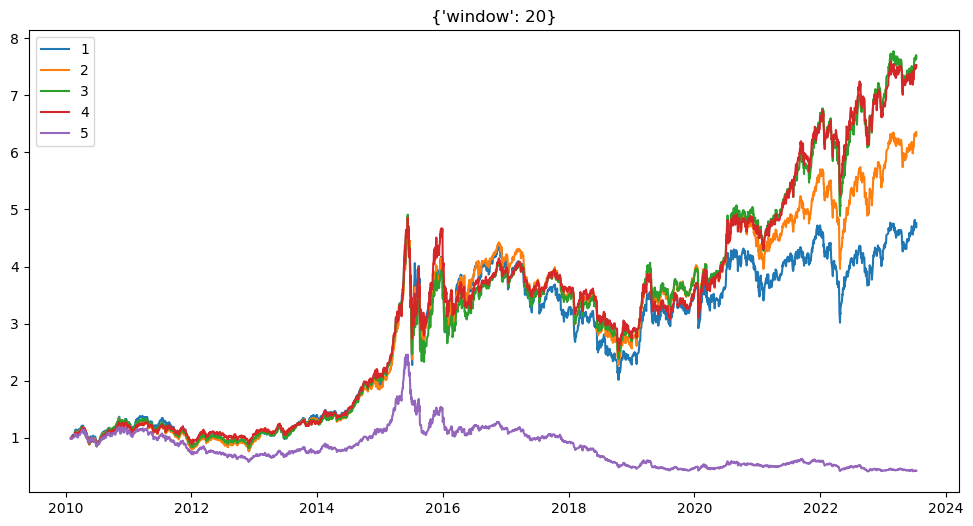

In [6]:
'''
Description: 
Author: czl
Date: 2023-07-21 16:19:19
LastEditTime: 2023-08-05 21:31:08
LastEditors:  
'''
reversal_developer = REVERSALFactorDeveloper()

mom_params_dict = {"window":[20]}
# reversal_developer.get_cumpord_return_df(mom_params_dict)
reversal_developer.get_cumprod_plots(parmas_dict=mom_params_dict)

100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


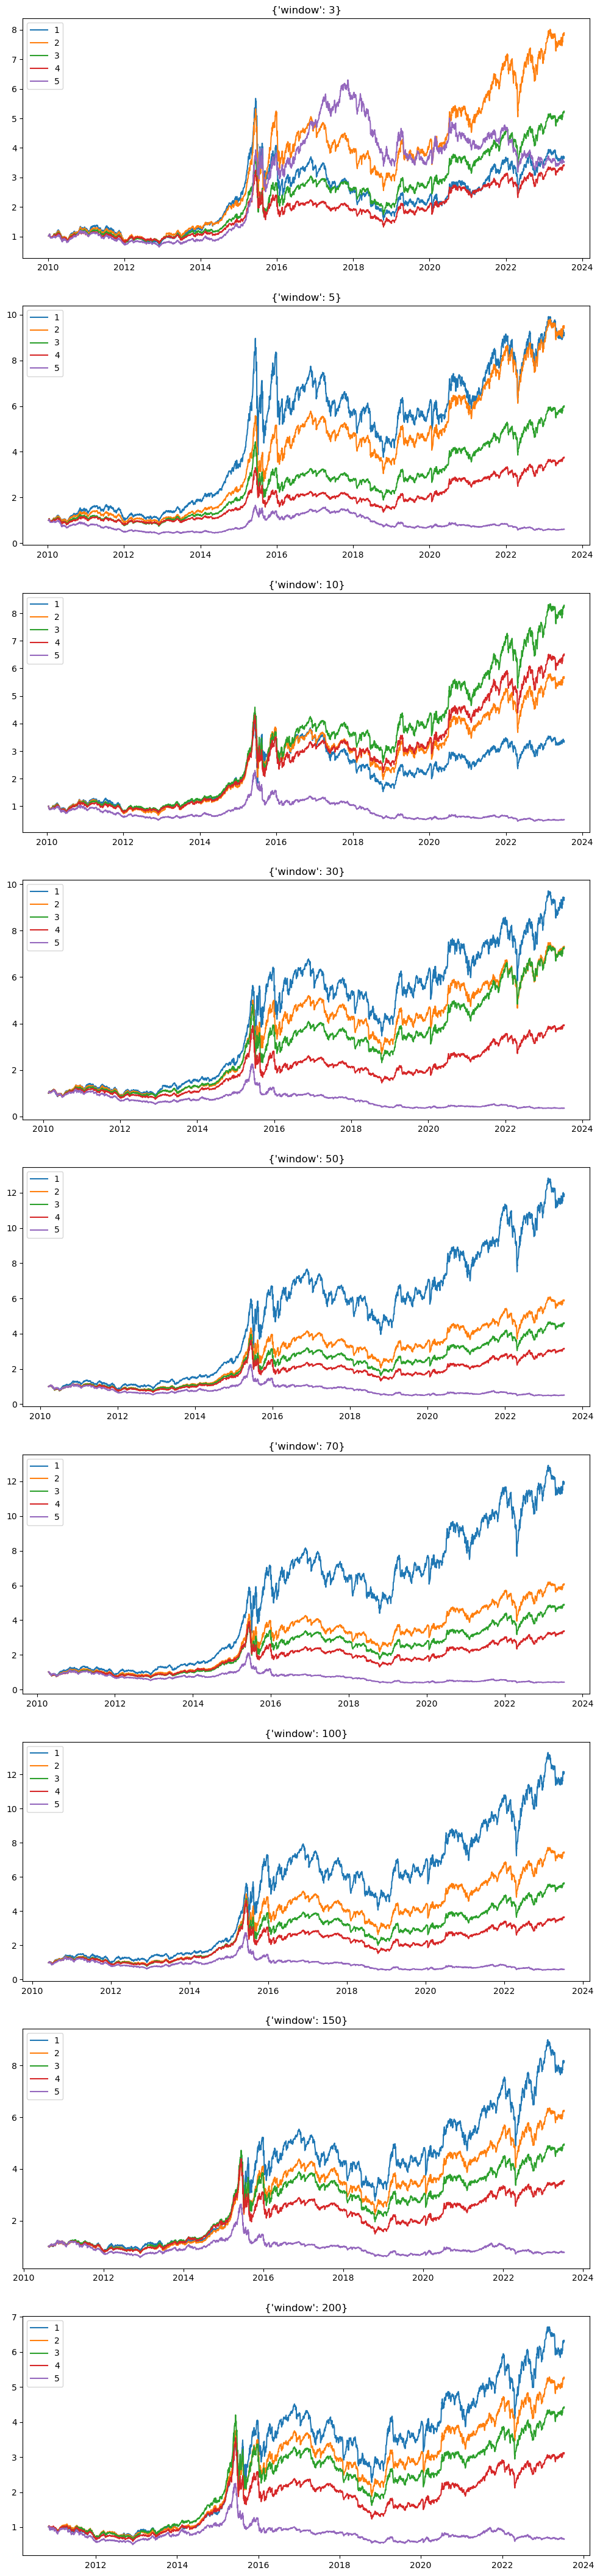

In [24]:
reversal_developer = REVERSALFactorDeveloper()

mom_params_dict = {"window":[3, 5, 10, 30, 50, 70, 100, 150, 200]}
# reversal_developer.get_cumpord_return_df(mom_params_dict)
reversal_developer.get_cumprod_plots(parmas_dict=mom_params_dict)

100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


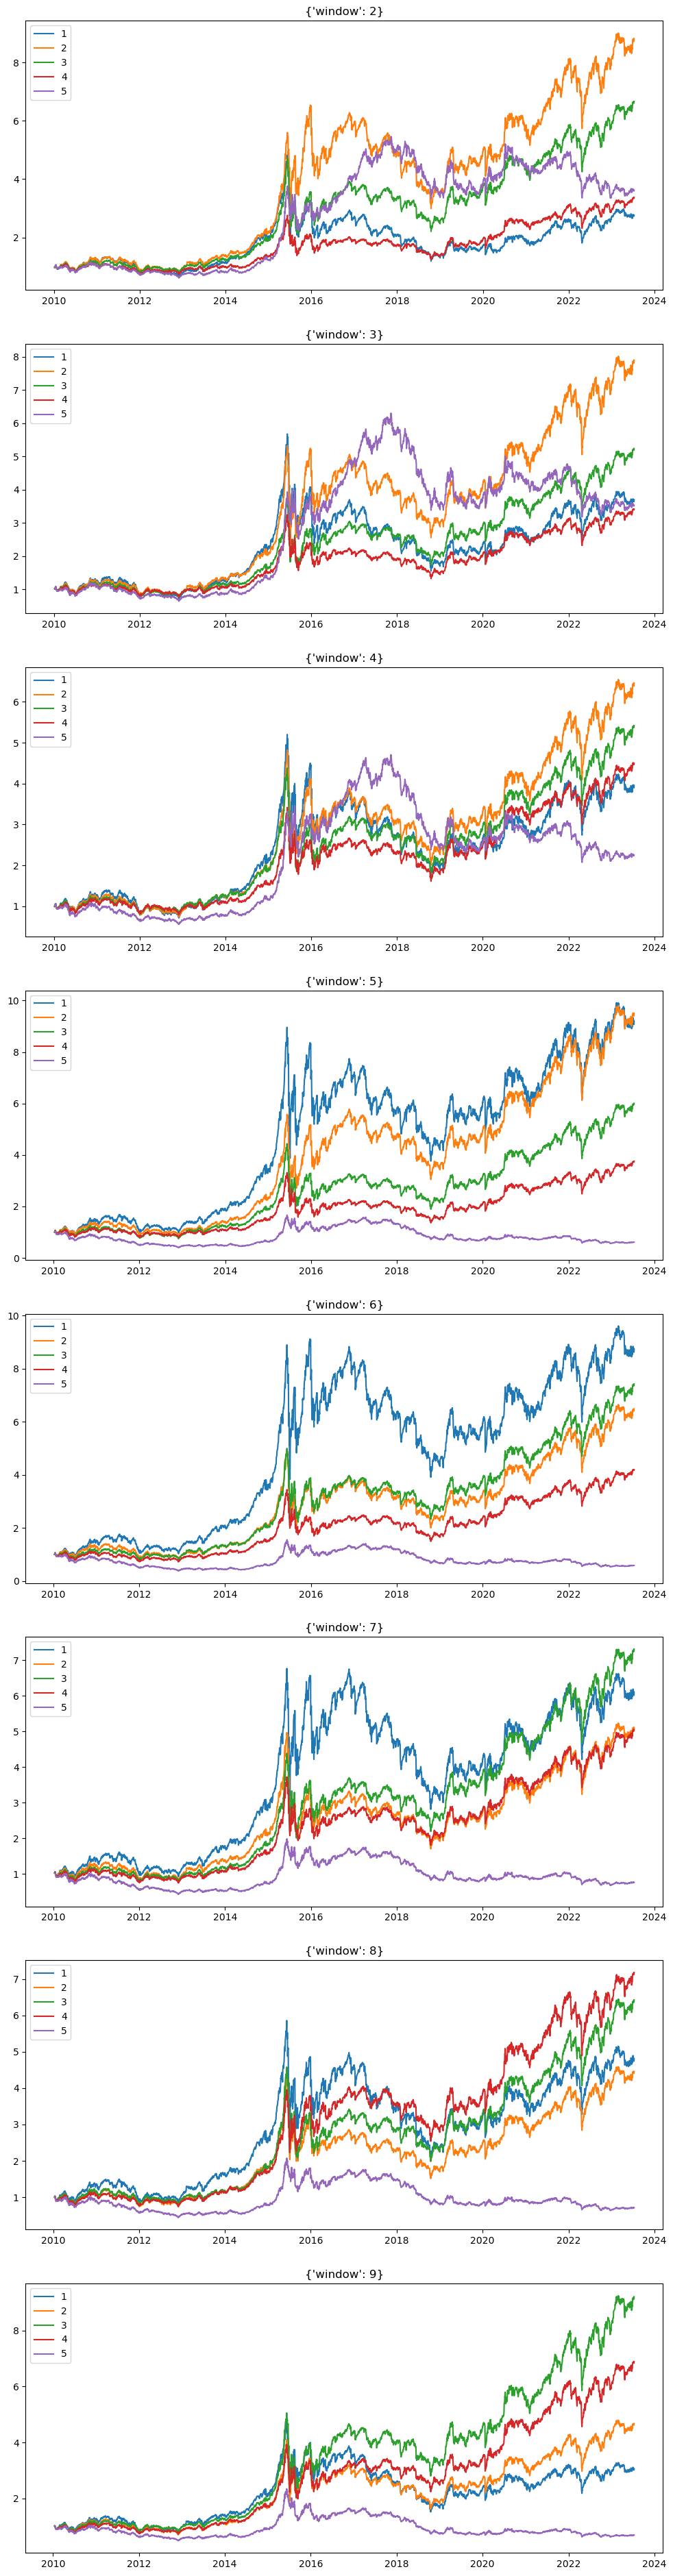

In [25]:
reversal_developer = REVERSALFactorDeveloper()

mom_params_dict = {"window":list(range(2,10))}
# reversal_developer.get_cumpord_return_df(mom_params_dict)
reversal_developer.get_cumprod_plots(parmas_dict=mom_params_dict)

结合以上，对于反转因子的窗口期有如下结论：
1. 当窗口期较短，10天以下时，各组的表现波动较大，并不具有持续性
2. 当窗口期较长，100天以上时，第一组的其它组别的差异显著下降
3. 较优的窗口期在30~100之间，该区间内，各组的表现较为稳定，同时第一组与其他组的差异明显，下面对该区间进一步测试

100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


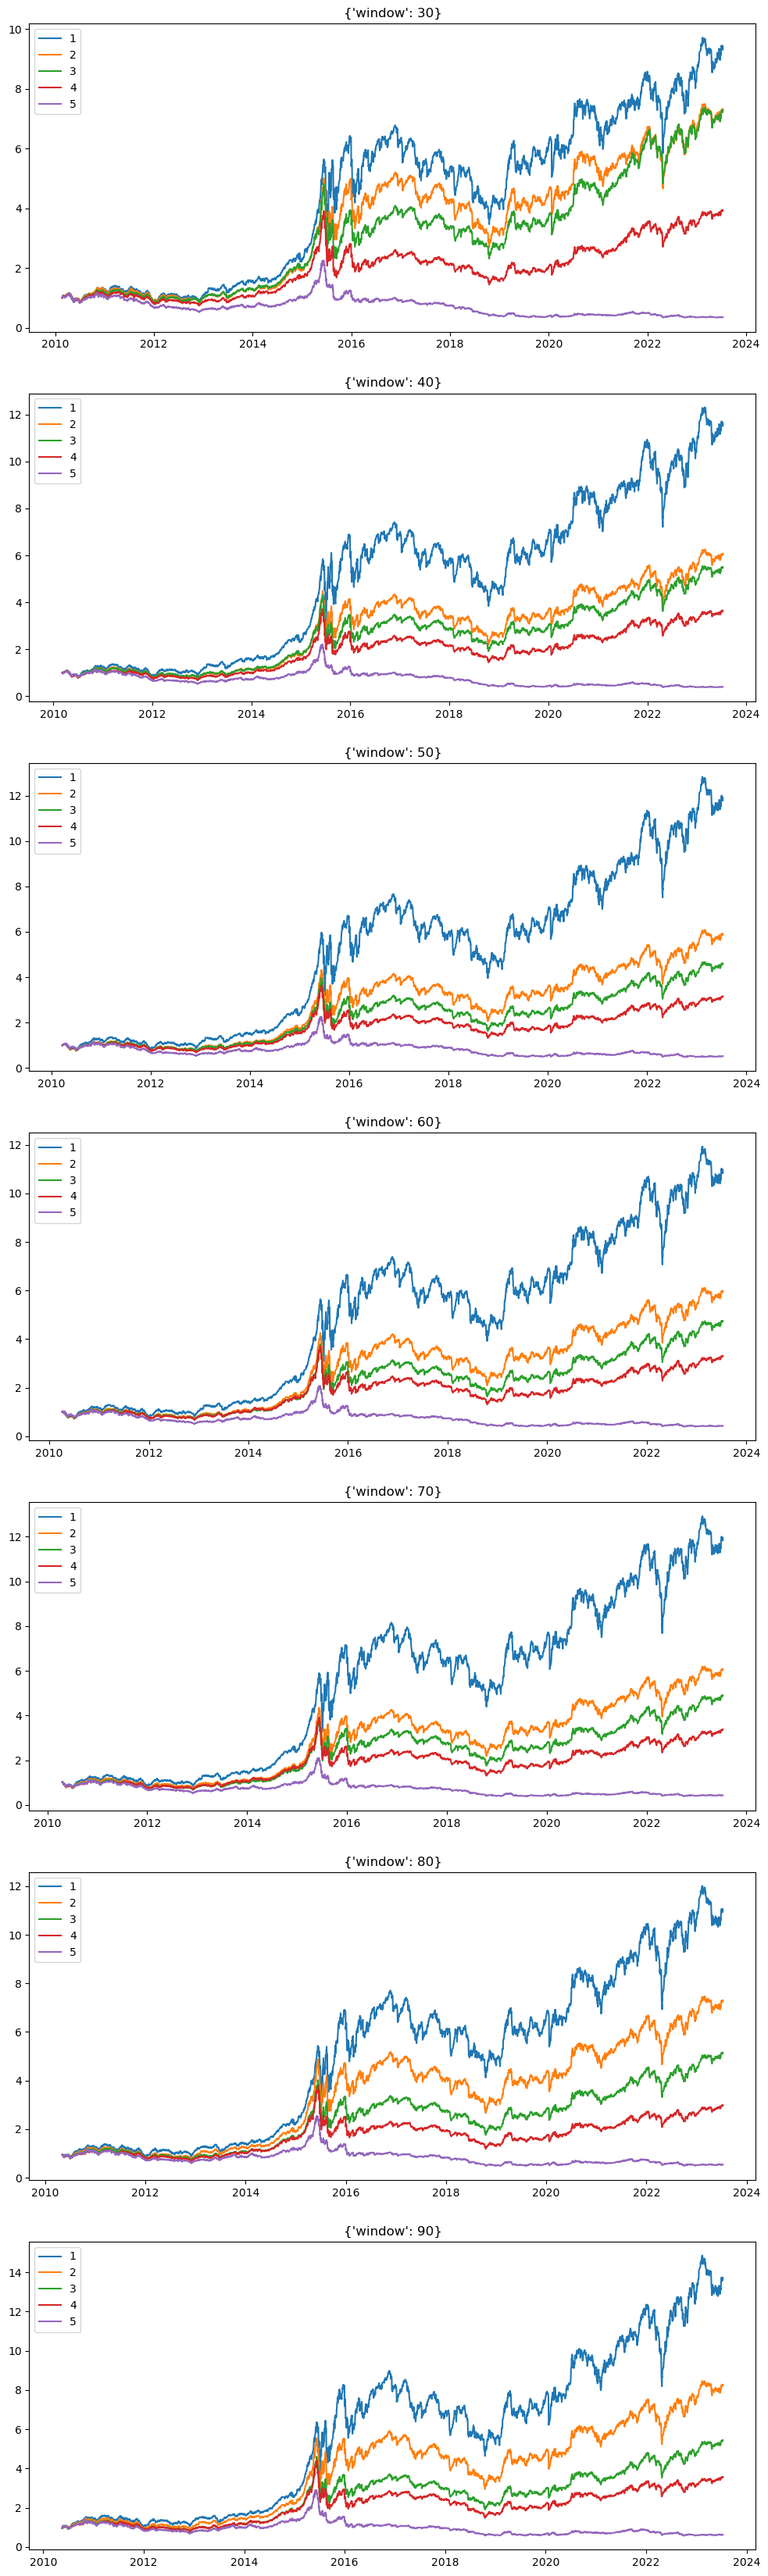

In [27]:
reversal_developer = REVERSALFactorDeveloper()

mom_params_dict = {"window":list(range(30,100,10))}
# reversal_developer.get_cumpord_return_df(mom_params_dict)
reversal_developer.get_cumprod_plots(parmas_dict=mom_params_dict)

最终，50天的窗口期为动量因子的最优窗口期。

带滑点和手续费

In [8]:
class CompletedREVERSALFactorDeveloper(FactorDeveloperTemplate):

    def __init__(self):
        super().__init__()
        pass

    def get_cumpord_return_df(self, params_group_dict):
        """
        used to get the cumprod return for different windows for reversal
        1. get the factor
        2. get the signal
        3. get the cumprod return
        """
        window = params_group_dict["window"]
        df_open = self.df_open

        df_reversal = get_reversal_factor(window)  # calcualte the factor

        # calculate the signal
        signal_generator = SignalGeneratorTemplate()
        df_signal = signal_generator.get_signal(df_reversal)

        # back test
        simple_back_tester = CompletedBackTester(open_df=df_open, singnal_df=df_signal)
        return simple_back_tester.get_tradable_cumprod_return()

    pass

100%|██████████| 6/6 [01:16<00:00, 12.76s/it]


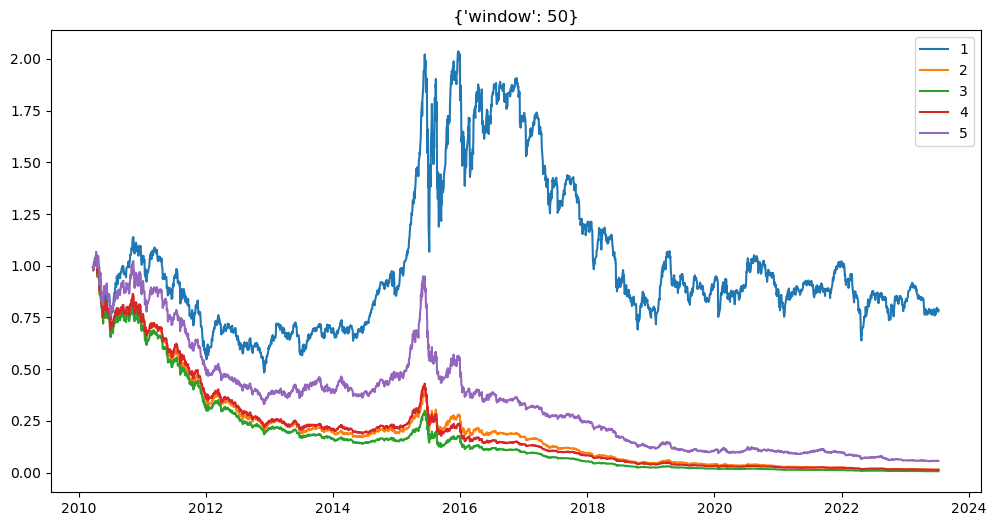

In [10]:
reversal_developer = CompletedREVERSALFactorDeveloper()

mom_params_dict = {"window":[50]}
# reversal_developer.get_cumpord_return_df(mom_params_dict)
reversal_developer.get_cumprod_plots(parmas_dict=mom_params_dict)

基本符合17年以后，A股市场动量失效的预期，后期与财务因子组合以后查看效果

## valuation 因子